# **Energy Consumption Time Series Forecast**

Project aim:

> This task aims to perform Time Series Forecasting on the Energy Consumption Dataset provided. Using the dataset, we are supposed to build a timeseries model and make predictions of the gas, electricity and water consuption using the test dataset.

# Importing Packages/Dataset

In [280]:
!pip install pandas-profiling

In [281]:
!pip install pmdarima

In [504]:
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import kpss

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv("Energy Consumption Dataset.csv")

# Exploratory Data Analysis

In [506]:
df.head()

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


In [284]:
df.describe()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
count,397.000000,397.000000,397.000000
mean,23.785139,888.472544,484.953652
std,4.903452,153.877594,133.908863
min,11.600000,553.200000,44.400000
25%,20.200000,771.100000,384.400000
50%,23.500000,897.800000,487.400000
75%,27.900000,1005.200000,580.200000
max,46.000000,1294.000000,811.000000


In [285]:
df.isna().sum()

DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

<font size = 6>

**Profile Report**

<font size = 3>

As we can see from the report, none of the features are very correlated to each other. Gas-Electricity and Electricity-Water have weak positive relationship while Gas-Water has a weak negative relationship.

In [287]:
from pandas_profiling import ProfileReport

prof = ProfileReport(df, explorative=True)

print("Summary")
print(f"Gas-Electricity = {df.corr()['Gas Consumption (tons)']['Electricity Consumption (MWh)']}")
print(f"Electricity-Water = {df.corr()['Electricity Consumption (MWh)']['Water Consumption (tons)']}")
print(f"Gas-Water = {df.corr()['Gas Consumption (tons)']['Water Consumption (tons)']}")


Summary
Gas-Electricity = 0.13505631764008444
Electricity-Water = 0.2220019044818366
Gas-Water = -0.38781340470929854


C:\Users\Fitri\AppData\Local\Temp\ipykernel_18308\3992481250.py:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_18308\3992481250.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_18308\3992481250.py:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<font size = 6>

**Timespan of Dataset**

Before performing a time series visualisation, I will need to make date the index of the dataset.

In [501]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")
df.set_index('DATE', inplace=True)

In [291]:
gas_df = df[['Gas Consumption (tons)']].copy()
electricity_df = df[['Electricity Consumption (MWh)']].copy()
water_df = df[['Water Consumption (tons)']].copy()

gas_df.head()

,Gas Consumption (tons)
DATE,
1990-01-01,18.0
1990-02-01,15.8
1990-03-01,17.3
1990-04-01,18.9
1990-05-01,22.0


Outliers in Series (First 5)


,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
2014-02-01,46.0,1044.2,44.4


No. of Outliers: 1


<Figure size 1000x600 with 0 Axes>

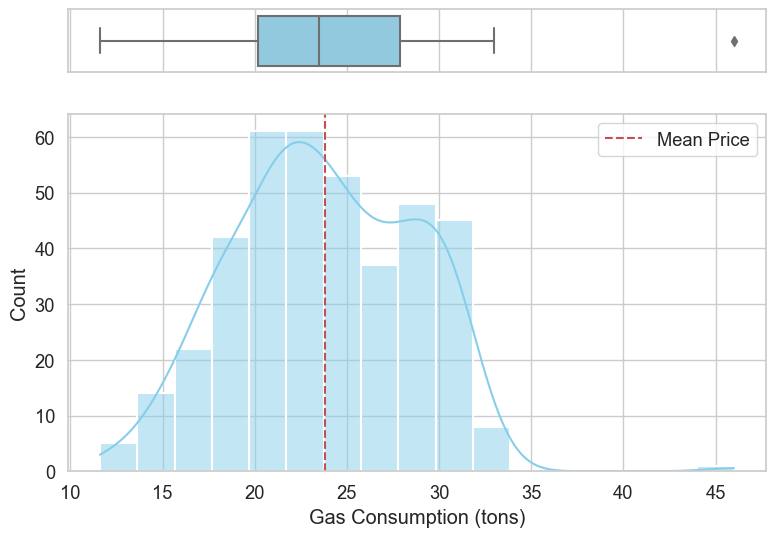

No Outliers


<Figure size 1000x600 with 0 Axes>

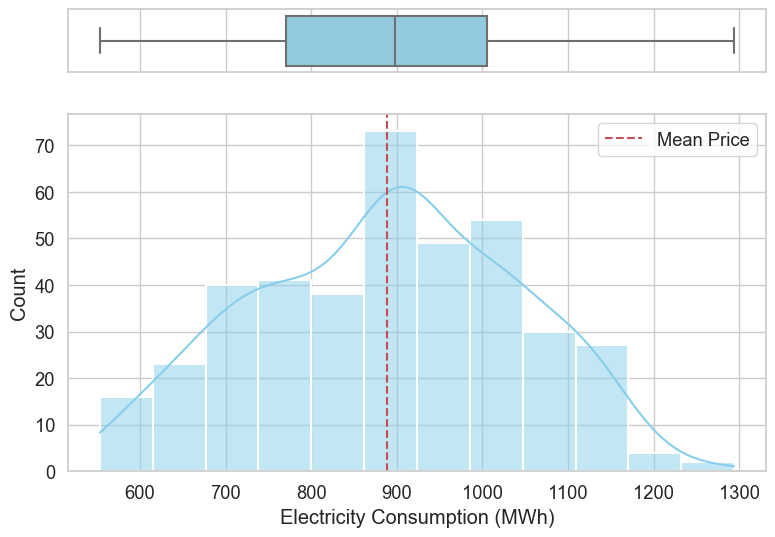

Outliers in Series (First 5)


,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
2014-02-01,46.0,1044.2,44.4


No. of Outliers: 1


<Figure size 1000x600 with 0 Axes>

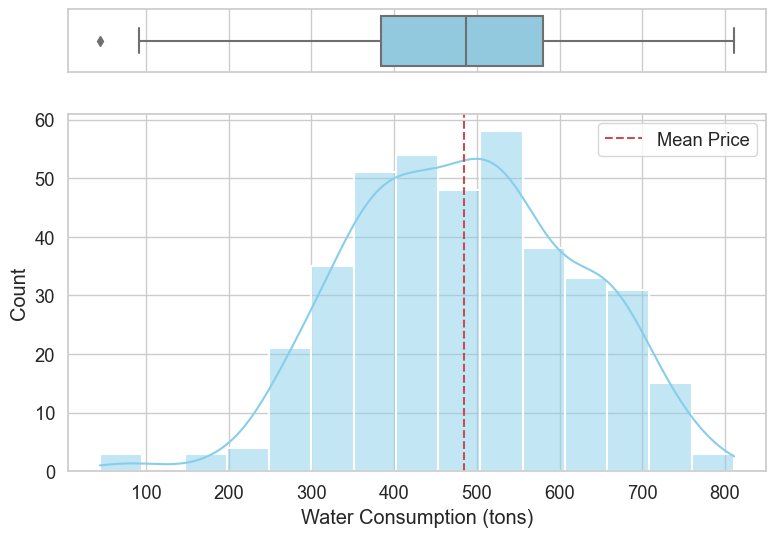

In [292]:
features = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']

for feature in features:
    sort = True
    deskew = True
    col = df[feature]
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (col > UpperFence) | (col < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        display(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))
    # boxplot and histplot together
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (9, 6))
    sns.boxplot(x= feature, data = df, ax=ax_box, color='skyblue')
    sns.histplot(x= feature , ax = ax_hist, kde=True, color='skyblue', edgecolor='white', linewidth=1.5, data= df)

    # find mean value
    mean = df[feature].mean()

    # create mean line on histogram 
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean Price")
    ax_hist.legend()
    ax_box.set(xlabel='')
    plt.show()

# **Time Series Analysis**

# Time Series Decomposition

In [293]:
from plotly.subplots import make_subplots
features = ['Gas Consumption (tons)','Electricity Consumption (MWh)','Water Consumption (tons)']
fig = make_subplots(rows=3, cols=1)

for i, feature in enumerate(features):
    fig.add_trace(go.Scatter(x=df.index, y=df[feature], name=feature), row=i+1, col=1)
    # add name to subplots
    fig.update_yaxes(title_text=feature, row=i+1, col=1)
    
fig.update_layout(height=800, width=1200, title_text="Time Series analysis of Gas, Electricity and Water Consumption")
fig.show()


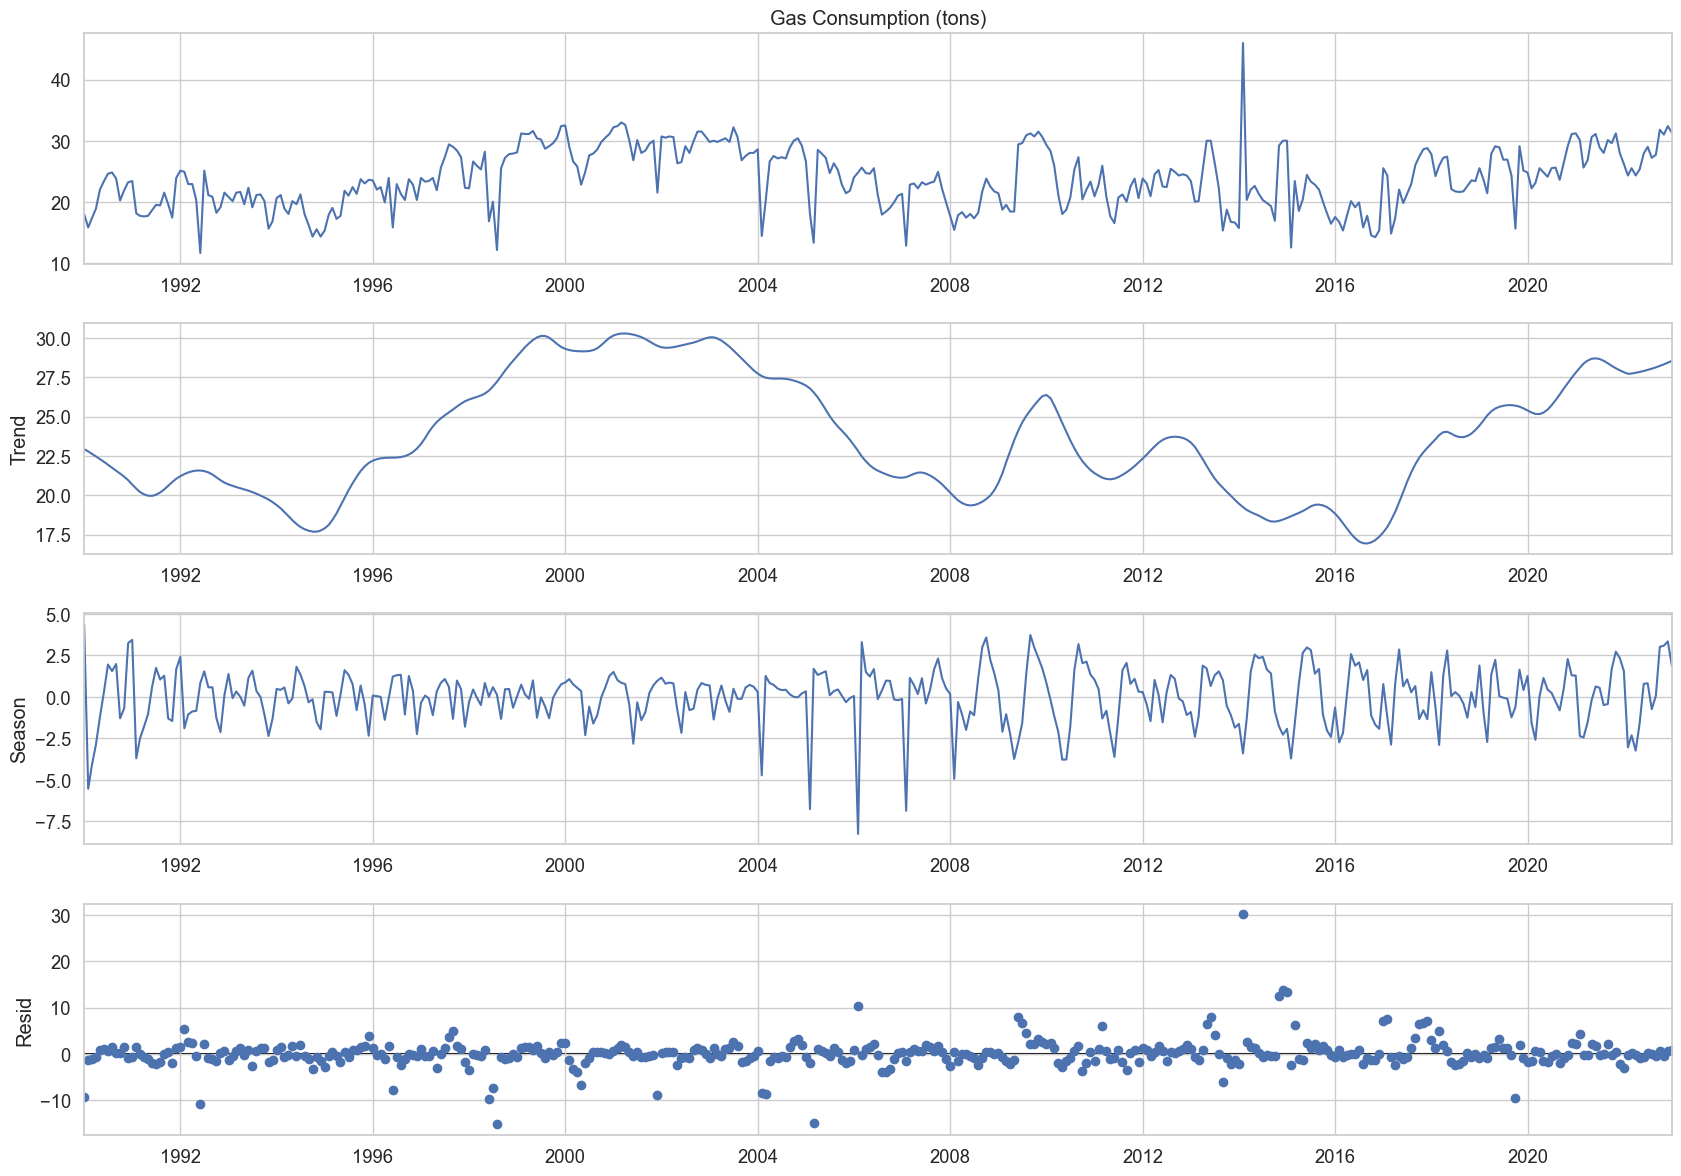

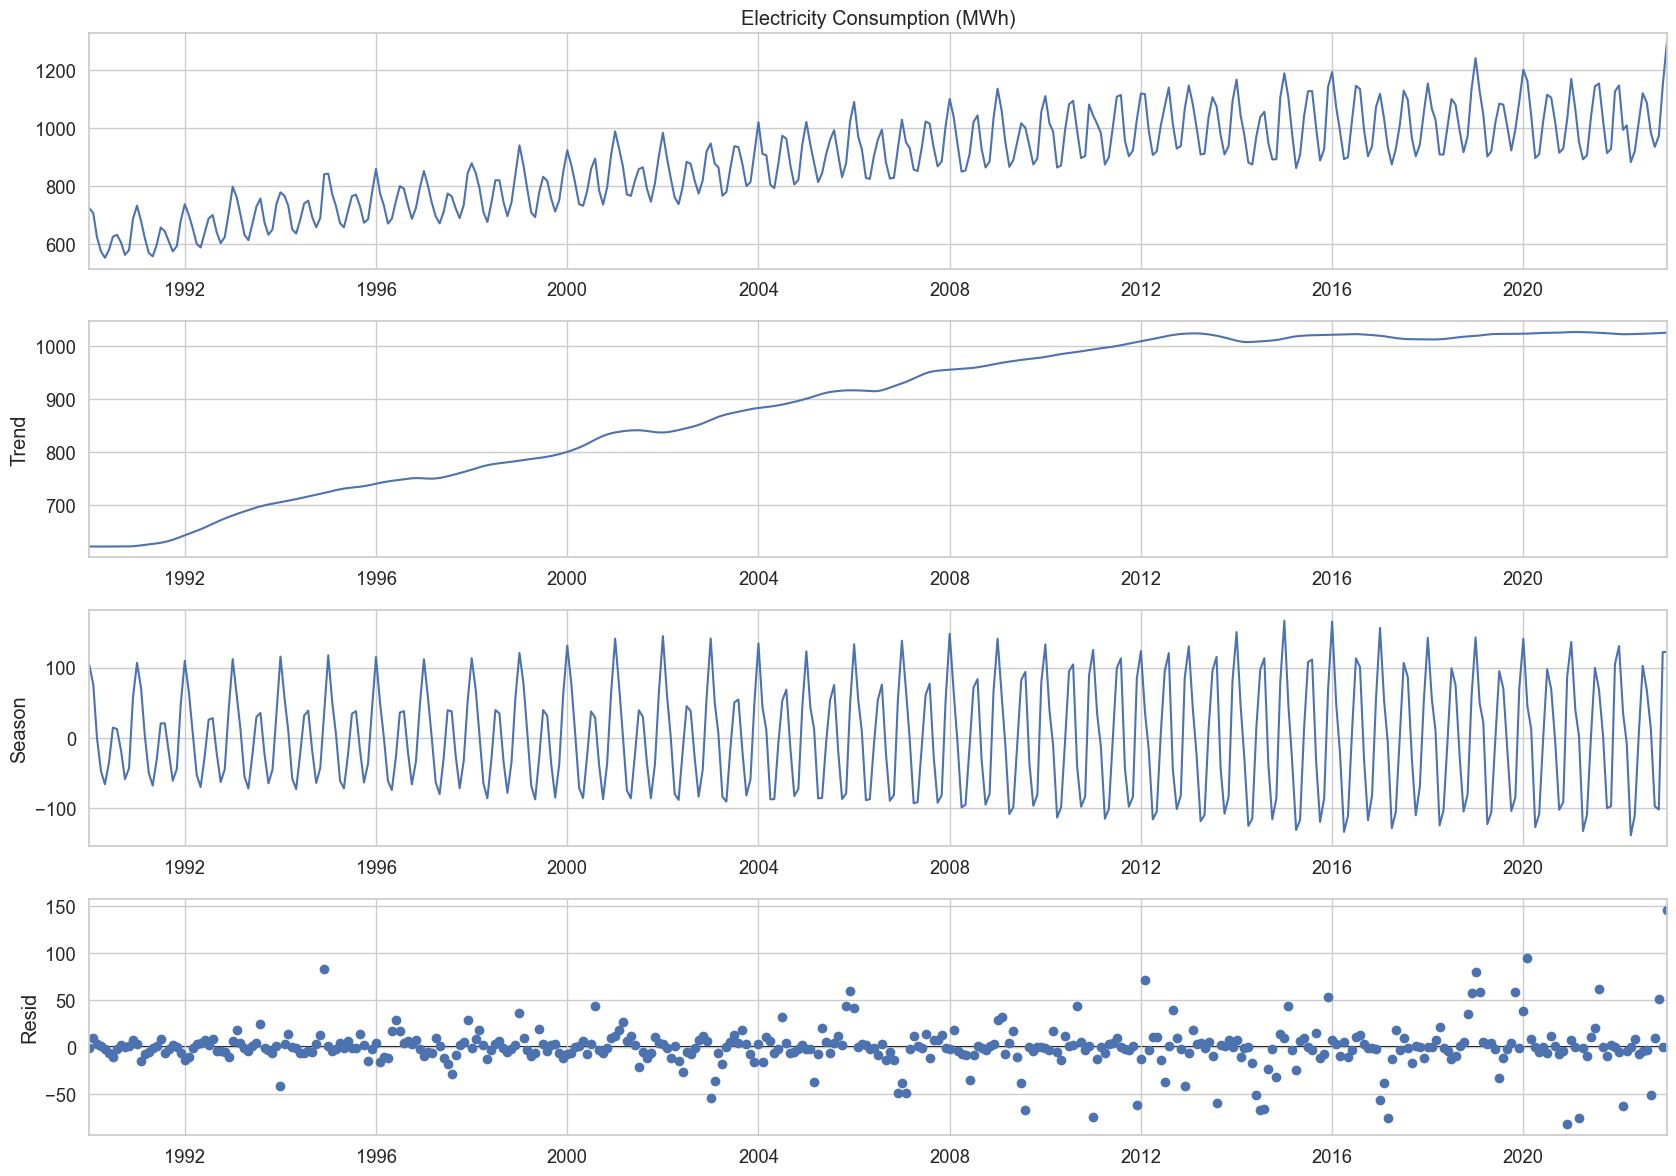

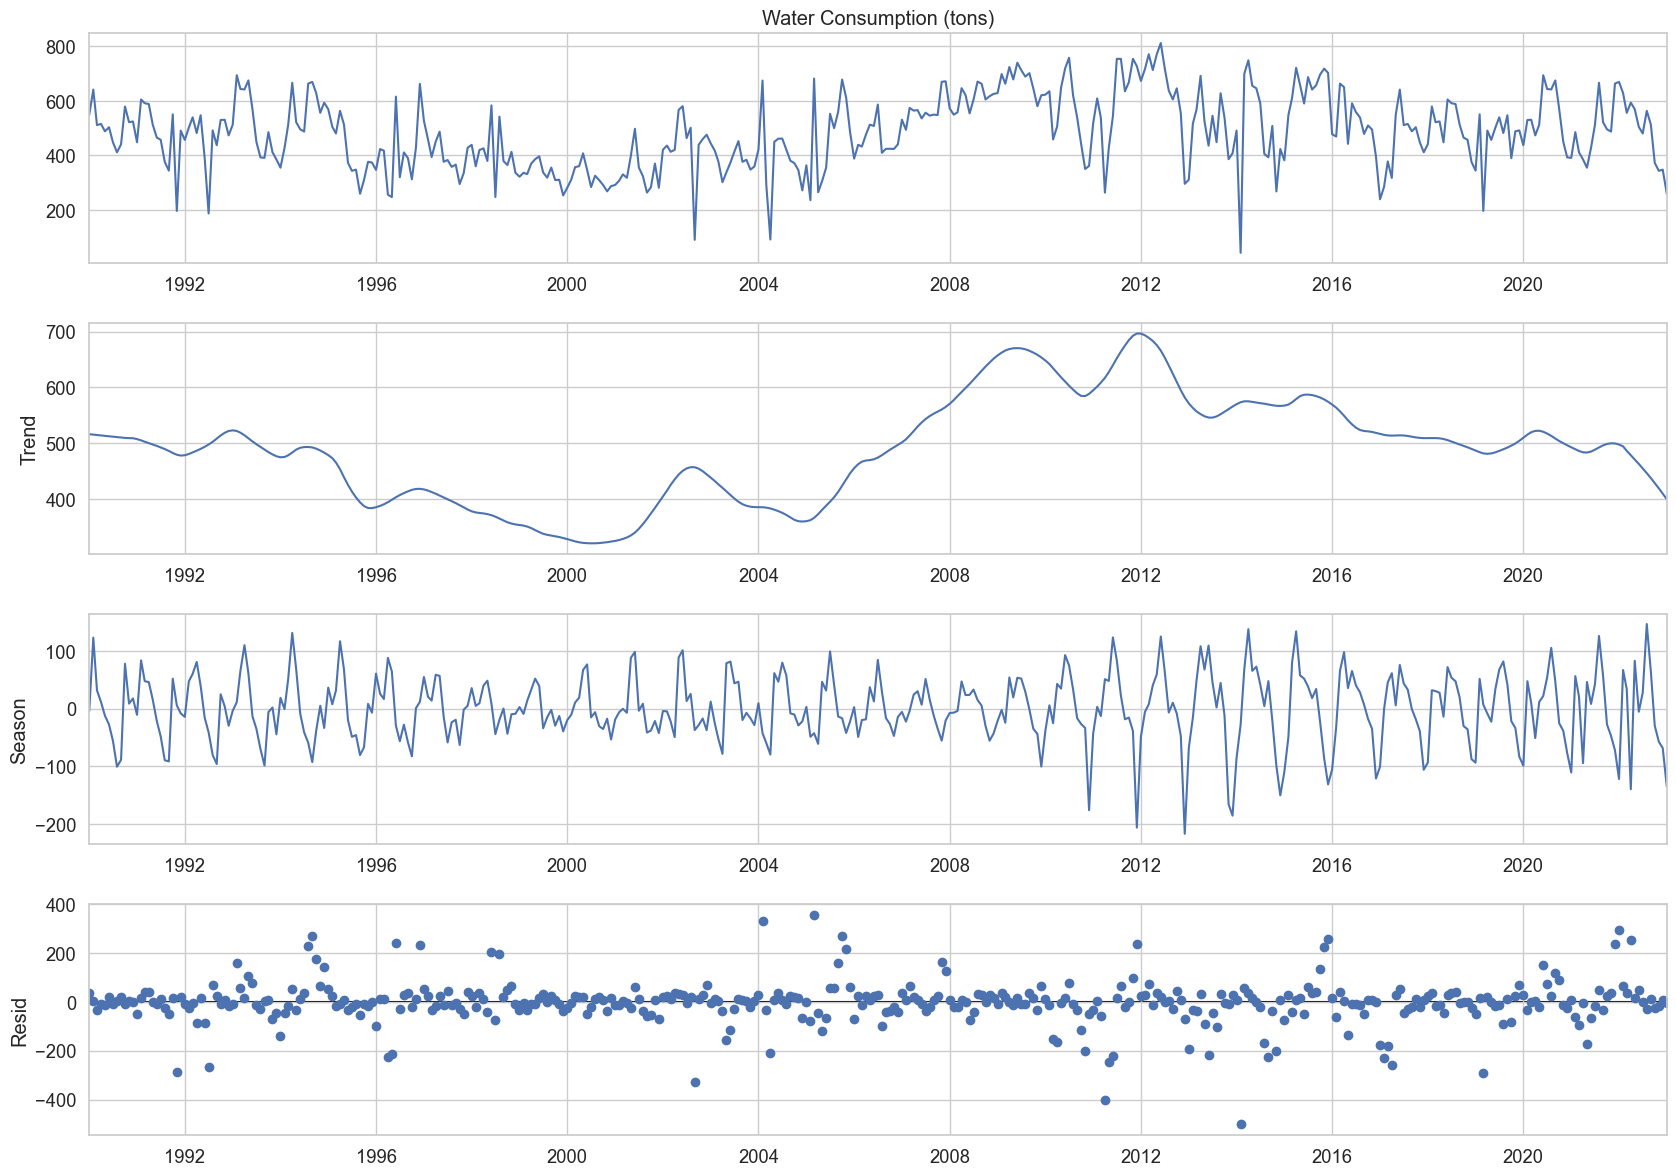

In [294]:
for feature in features:
    plt.rcParams['figure.figsize'] = (17, 12)
    res = STL(df[feature], robust=True).fit()
    res.plot()
    plt.show()

    

## Dickey Fuller Test for Stationarity Series
To model a time-series using ARMA model, we need to ensure the time-series is stationary, that is the the mean, variance and covariance does not vary with time.

To verify stationarity, we will be utilising Augmented Dickey Test,where my significant value, ${p}$, = 0.05. My null hypothesis and alternative hypothesis are:

${H_0}$: Time series is non stationary when ${p}$ > 0.05, and ${H_1}$: Time series is stationary when ${p}$ < 0.05 respectively 

In [508]:
def adfuller_test(data):
    for feature in features:
        print(f'ADF Results for {feature} feature')
        print('-'*40)
        print(f'ADF Statistic: {adfuller(data[feature])[0]}')
        print(f'p-value: {round(adfuller(data[feature])[1], 5)}')
        print('Level of significance: 5%')

        # check if p value is less than 0.05, if so, the data is stationary
        if adfuller(data[feature])[1] < 0.05:
            print('Null hypothesis rejected, data is stationary')
        else:
            print('Null hypothesis accepted, data is not stationary')
        print('\n')
adfuller_test(df)

ADF Results for Gas Consumption (tons) feature
----------------------------------------
ADF Statistic: -3.4043743333182723
p-value: 0.01081
Level of significance: 5%
Null hypothesis rejected, data is stationary


ADF Results for Electricity Consumption (MWh) feature
----------------------------------------
ADF Statistic: -2.2569805495925452
p-value: 0.18622
Level of significance: 5%
Null hypothesis accepted, data is not stationary


ADF Results for Water Consumption (tons) feature
----------------------------------------
ADF Statistic: -4.684845541682445
p-value: 9e-05
Level of significance: 5%
Null hypothesis rejected, data is stationary




# KPSS Test for Stationarity Series

Next, I will be using a different method to check for stationarity, called the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. I use this in addition to ADF as it has the capability to check for stationarity in the presence of a deterministic trend. When there is a deterministic trend in data theres a few solutions to this:

- Trend Removal
- Seasonal Adjustment

In [296]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    # print(kpss_output)
    return kpsstest

for feature in features:
    result = kpss_test(df[feature])
    p_value = result[1]
    print(f"P-value for {feature}: {p_value}")
    if p_value < 0.05:
        print("The series is not stationary (reject the null hypothesis)")
    else:
        print("The series is stationary (fail to reject the null hypothesis)")
        print()

Results of KPSS Test:
P-value for Gas Consumption (tons): 0.1
The series is stationary (fail to reject the null hypothesis)

Results of KPSS Test:
P-value for Electricity Consumption (MWh): 0.01
The series is not stationary (reject the null hypothesis)
Results of KPSS Test:
P-value for Water Consumption (tons): 0.01
The series is not stationary (reject the null hypothesis)


c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [298]:
#Defining the current ambiguous column (the one we want to test for stationarity)
ambcol = ['Water Consumption (tons)']

significance_level = 0.05
for feature in ambcol:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f'\n{feature},difference=1')
        print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary \nH1: There is a unit root (non-stationary)")
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature].diff().dropna(), regression="c", nlags= 1)
        print(f'KPSS Statistic: {test_statistic}')
        print(f"P-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Reject H0. There is evidence that the time series is not stationary.")
        else:
            print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
        display(test_statistic, pvalue, usedlag)


Water Consumption (tons),difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.01048838030710567
P-value: 0.100
Used Lag: 1
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.01048838030710567

0.1

1

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. In this paper, we adapted the granger causality test to validate that the features are related in forecasting the energy consumption.

$H_{0}$ : X does not granger cause Y

$H_{1}$ : X does granger cause Y

In [299]:
from statsmodels.tsa.stattools import grangercausalitytests

relate = pd.DataFrame({'Gas1': [], 'Gas2': [], 'p-value': []})

for i in range(len(features)):
    for j in range(i+1, len(features)):
        gas1 = features[i]
        gas2 = features[j]
        result = grangercausalitytests(df[[gas1, gas2]], maxlag=1)
        p_value = result[1][0]['ssr_ftest'][1]
        relate = relate.append({'Gas1': gas1, 'Gas2': gas2, 'p-value': p_value}, ignore_index=True)
        if p_value < 0.05:
            print(f'{gas1} Granger causes {gas2}')
        else:
            print(f'{gas1} does not Granger cause {gas2}')

print(relate)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0381  , p=0.8454  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.0384  , p=0.8447  , df=1
likelihood ratio test: chi2=0.0384  , p=0.8447  , df=1
parameter F test:         F=0.0381  , p=0.8454  , df_denom=393, df_num=1
Gas Consumption (tons) does not Granger cause Electricity Consumption (MWh)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0179  , p=0.8935  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.0181  , p=0.8930  , df=1
likelihood ratio test: chi2=0.0181  , p=0.8930  , df=1
parameter F test:         F=0.0179  , p=0.8935  , df_denom=393, df_num=1
Gas Consumption (tons) does not Granger cause Water Consumption (tons)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3296  , p=0.5662  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.3321  , p=0.5644  , df=1
likelihood ratio test: chi2=0.3319  , p=0.5645  , df=1
parameter F test:   

C:\Users\Fitri\AppData\Local\Temp\ipykernel_18308\2237403048.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_18308\2237403048.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_18308\2237403048.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



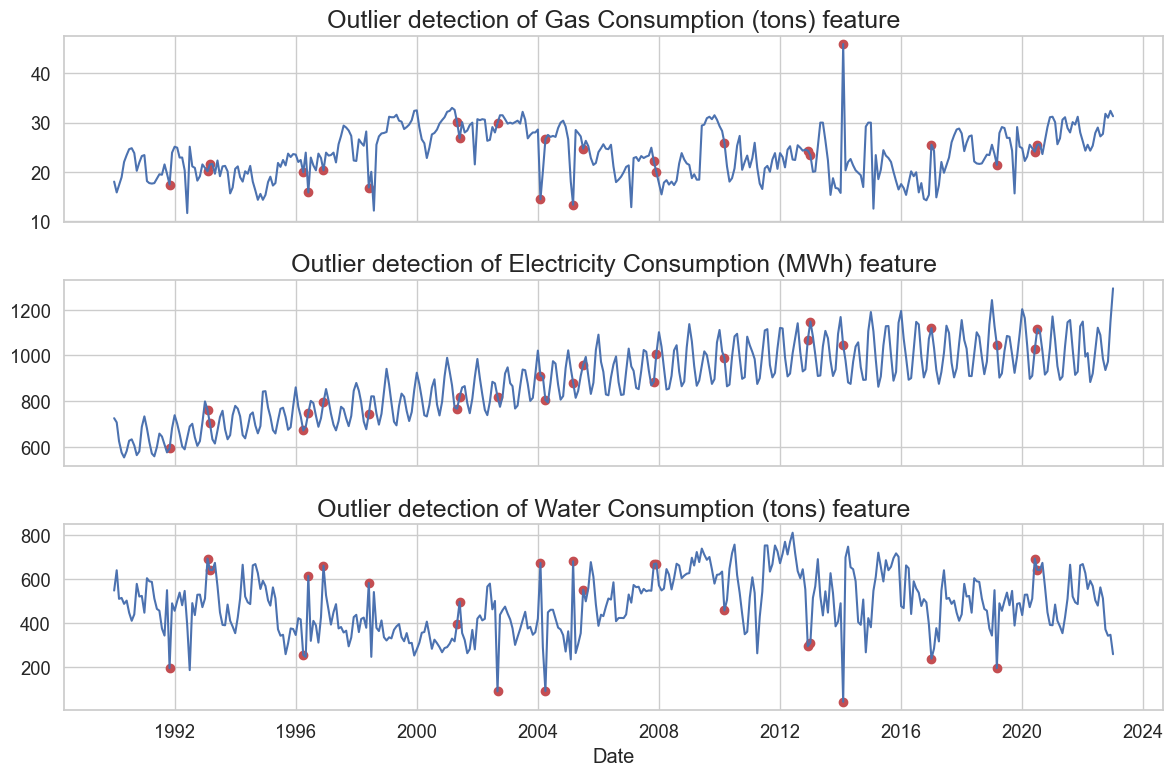

In [297]:
# Set the window size for the rolling IQR
window_size = 12
k = 1.5
outliers_list = []

rolling_iqr_gas = df['Gas Consumption (tons)'].rolling(window = window_size).quantile(0.75) - df['Gas Consumption (tons)'].rolling(window = window_size).quantile(0.25)
rolling_iqr_electricity = df['Electricity Consumption (MWh)'].rolling(window = window_size).quantile(0.75) - df['Electricity Consumption (MWh)'].rolling(window = window_size).quantile(0.25)
rolling_iqr_water = df['Water Consumption (tons)'].rolling(window = window_size).quantile(0.75) - df['Water Consumption (tons)'].rolling(window = window_size).quantile(0.25)

lower_bound_gas = df['Gas Consumption (tons)'].rolling(window = window_size).quantile(0.25) - k * rolling_iqr_gas
upper_bound_gas = df['Gas Consumption (tons)'].rolling(window = window_size).quantile(0.75) + k * rolling_iqr_gas

lower_bound_electricity = df['Electricity Consumption (MWh)'].rolling(window = window_size).quantile(0.25) - k * rolling_iqr_electricity
upper_bound_electricity = df['Electricity Consumption (MWh)'].rolling(window = window_size).quantile(0.75) + k * rolling_iqr_electricity

lower_bound_water = df['Water Consumption (tons)'].rolling(window = window_size).quantile(0.25) - k * rolling_iqr_water
upper_bound_water = df['Water Consumption (tons)'].rolling(window = window_size).quantile(0.75) + k * rolling_iqr_water

outliers_gas = (df['Gas Consumption (tons)'] < lower_bound_gas) | (df['Gas Consumption (tons)'] > upper_bound_gas)
outliers_electricity = (df['Electricity Consumption (MWh)'] < lower_bound_electricity) | (df['Electricity Consumption (MWh)'] > upper_bound_electricity)
outliers_water = (df['Water Consumption (tons)'] < lower_bound_water) | (df['Water Consumption (tons)'] > upper_bound_water)

for feature in features:
    rolling_iqr = df[feature].rolling(window = window_size).quantile(0.75) - df[feature].rolling(window = window_size).quantile(0.25)
    lower_bound = df[feature].rolling(window = window_size).quantile(0.25) - k * rolling_iqr
    upper_bound = df[feature].rolling(window = window_size).quantile(0.75) + k * rolling_iqr
    outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    outliers_list.append(outliers)

# # Create a figure and axes
# fig, axes = plt.subplots(len(outliers_list), 1, figsize=(10, len(outliers_list) * 6))

# for i, feature in enumerate(outliers_list):
#     ax = axes[i]
#     ax.plot(data.index, data[features[i]])
#     ax.scatter(x=feature.index, y=data[features[i]][feature], color='r')
#     ax.set_title(f'Outlier detection of {features[i]} feature', fontsize=18)

# # Set the x-axis label
# axes[-1].set_xlabel('Date')

# # Adjust the spacing between subplots
# fig.tight_layout()

# # Show the plot
# plt.show()

fig, axes = plt.subplots(len(features), 1, figsize=(12, 8), sharex=True)

for i, feature in enumerate(outliers_list):
    ax = axes[i]
    ax.plot(df.index, df[features[i]])
    ax.scatter(x=df.index[outliers], y=df[features[i]][outliers], color='r')
    ax.set_title(f'Outlier detection of {features[i]} feature', fontsize=18)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Checking For Cointegration
Even though cointegration requires 2 non stationary features, as water is ambiguous, I feel that we should test just in case to view whether there is cointegration.

In [300]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

for i in range(len(features)):
    for j in range(i+1, len(features)):
        gas1 = features[i]
        gas2 = features[j]
        data = df[['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']]
        result = coint_johansen(data, det_order = 0, k_ar_diff=1)

        p_values = result.lr1
        significance_level = 0.05
        significant_p_values = p_values < significance_level

        if any(significant_p_values):
            print("There is evidence of cointegration among the variables.")
            for i, p_value in enumerate(p_values):
                if p_value < significance_level:
                    print(f"Variable {i+1}: p-value = {p_value:.4f} (significant)")
                else:
                    print(f"Variable {i+1}: p-value = {p_value:.4f}")
        else:
            print(f"There is no evidence of cointegration between {gas1} and {gas2}")

There is no evidence of cointegration between Gas Consumption (tons) and Electricity Consumption (MWh)
There is no evidence of cointegration between Gas Consumption (tons) and Water Consumption (tons)
There is no evidence of cointegration between Electricity Consumption (MWh) and Water Consumption (tons)


## Auto-Correlation & Partial Auto-Correlation Plot
After ensuring our time-series is stationary, ACF and PACF can be helpful for us to get a sense on how previous values can be useful for us to predict the current value for each different gasses. However, we saw that there was an ambiguous column. In this case, I will not assume stationarity first, and see if using the differenced Water Consumption produces better results in the end.

c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



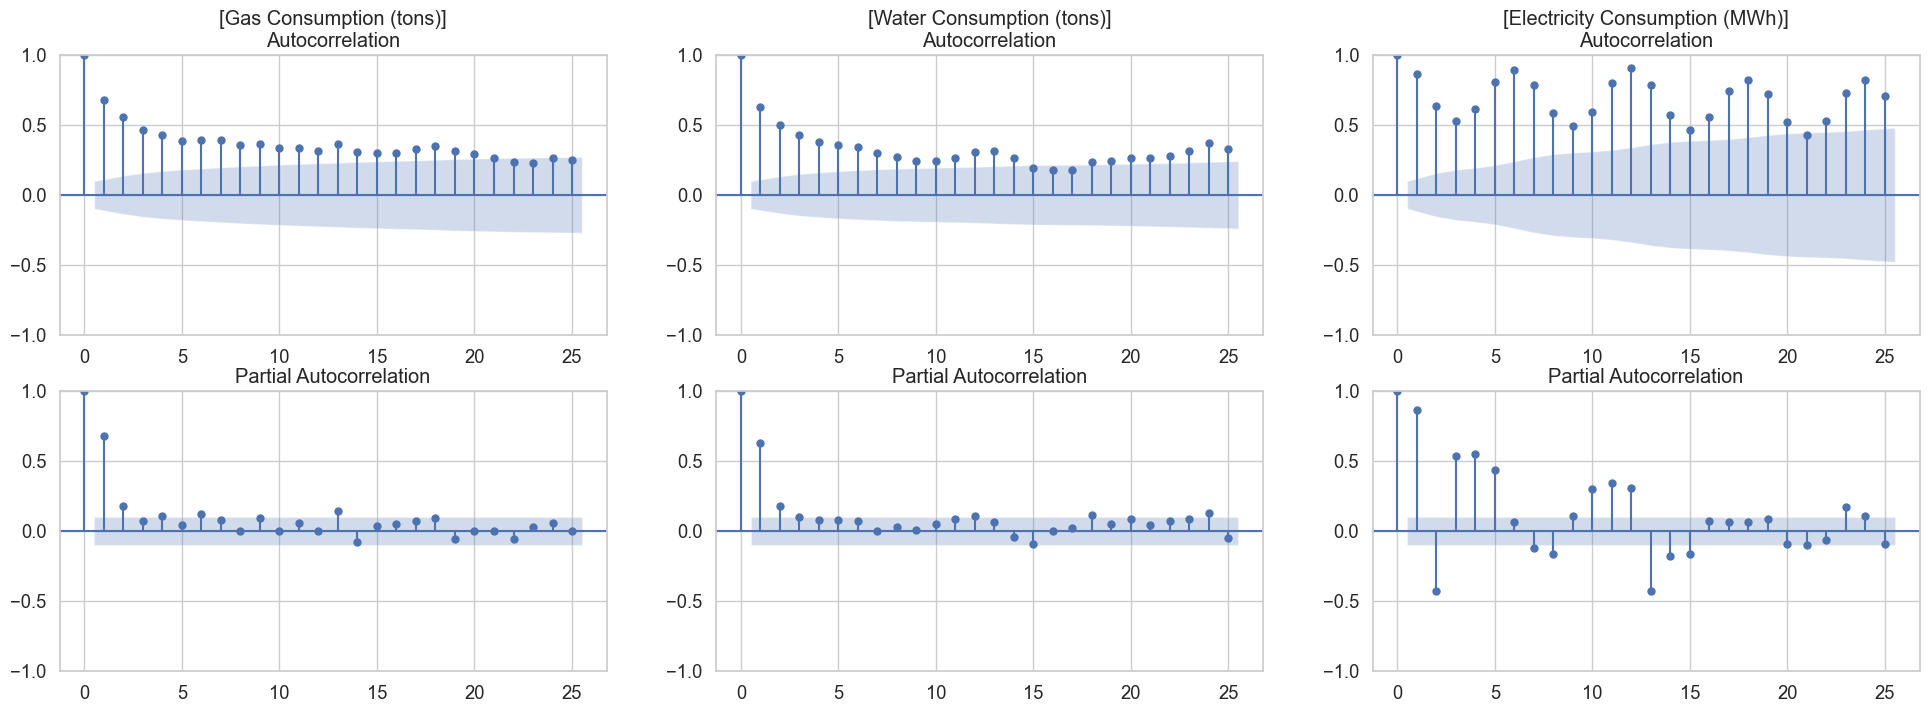

In [301]:
import matplotlib.pyplot as plt
new_features = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']

fig, axes = plt.subplots(2,3, figsize = (24,8))
for idx, feature in enumerate(new_features):
    plot_acf(df[feature], lags = 25, ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df[feature], lags = 25, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(feature))
plt.show()

Before thinking about the orders of the models, we have to understand that in this project, there are no exogenous variables. Therefore, this lowers the number of models that can be used such as SARIMAX, as they require exogenous features.


### **Observations**
For all resources, `Gas`, `Electricity` and `Water`, the PACF plots all show a spike at only lag 1, thus indicating that the lag 1 is the most significant lag for all 3 resources, meaning that correlations at all other lags are explained by correlation at lag 1.

Electricity has seasonal correlation when looking at its ACF. Ignoring the lag 0 and 1, there is a pattern that repeats every 6 lags.


### **Model Summary for each resource**

Note that since I didn't difference electricity earlier, I will be using d = 1.

| Resources | AR(p significant lags) | MA(q significant lags) | Seasonal Trend | Potential Initial Model |
| :----: | :---: | :---: | :---: | :---: |
| Gas | 1 | 1 |Weak Seasonal Trend every 12 iterations| MA(1)/ AR(1)/ ARMA(1,1)/SARIMA(1,0,1)(1,0,1,12)|
| Electricity | 1 | 1 | Strong Seasonal Trend every 6 iterations |MA(1)/ AR(1)/ ARMA(1,1)/SARIMA(1,1,1)(1,0,1,6)|
| Water | 1 | 1 |Weak Seasonal Trend every 11 iterations |MA(1)/ AR(1)/ ARMA(1,1)/SARIMA(1,1,1)(1,0,1,11)|

In [303]:
pd.DataFrame({'Name':['Gas','Electricity','Water'],'Order':['(1,0,1)','(1,1,1)','(1,0,1)']})

,Name,Order
0,Gas,"(1,0,1)"
1,Electricity,"(1,1,1)"
2,Water,"(1,0,1)"


# Univariate Time-Series Modelling

## Sampling Technique: Expanding or Sliding Window?
I think the advantages and disadvantages of both methods are very telegraph when described.

### Expanding
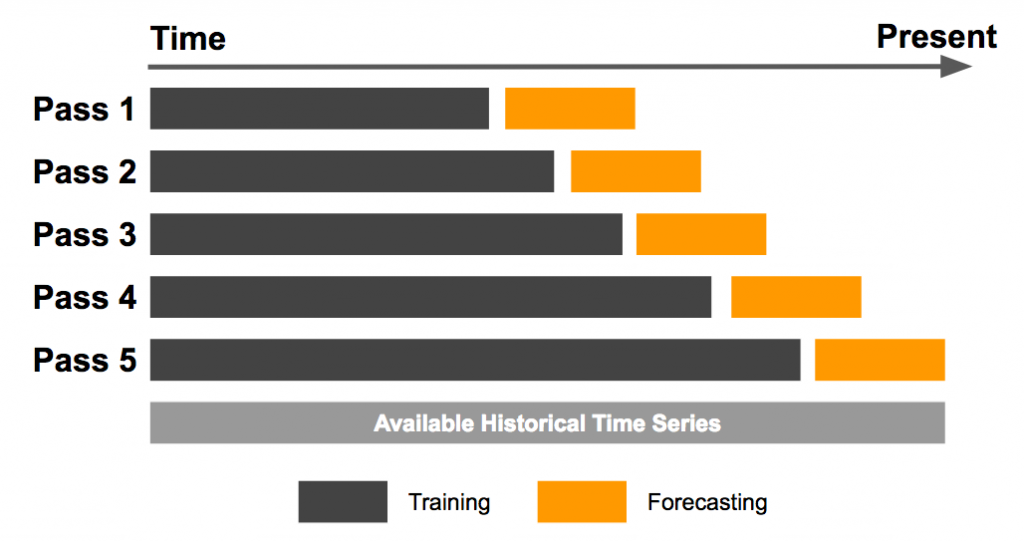<br>
In expanding window sampling, the training set gradually increases in size as new observations become available. Each new observation is added to the existing training set, and the model is retrained on the expanded training set. This allows the model to learn from an increasing amount of data over time, reflecting the real-world scenario where historical data is readily available.

Due to expanding window constantly increasing in size in terms of observations, it is able to learn from an increasing amount of said observaations, which is beneficial in finding long-term trends or seasonality patterns in the data. However, due to the inclusion of all historical data, as the amount of data increases, the earliest observations will have a higher weightage, which may not be representative of the most recent patterns or dynamics in the time series. A strong example would be a very reoccuring pattern at first, that experiences sudden change. Expanding window would most likely prioritise previous patterns over more recent ones. With that, expanding window would do better in long term predicting as it is able to work better with more and more observations. It is able to capture long term trends due to the amount of data it is working with. In summary, the expanding window approach provides a comprehensive view of the time series over the entire data set. However, it may be less sensitive to recent changes and variations. It is more suitable for time series with stable and persistent patterns, where long-term behavior is of greater importance than short-term fluctuations.


### Sliding
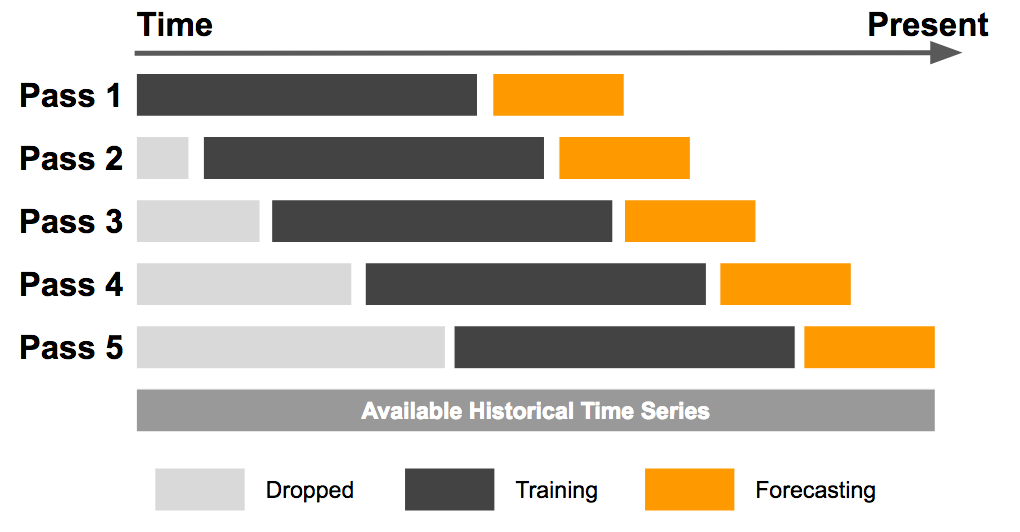<br>
In sliding window sampling, a fixed-size window is used to train the model. The window moves forward in time with each iteration, and the model is trained on a new subset of data within the window. The window size remains constant, and the model does not have access to past observations outside the window. This approach simulates a scenario where only a limited historical context is available for making predictions.

On the other hand, sliding window uses a constant amount of observations, giving a better gauge of how good the model is. This allows the model to capture the most up-to-date patterns and dynamics in the time series. It focuses on a specific time frame and adapts to changes within that window, providing a more accurate estimate of the model's predictive capabilities within that specific time frame. As it is constantly working with the most recent data and discarding the (relatively) older data, it is able to adapt better to recent trends. However, due to the high weightage on recent trends and the discard of older observations, it has very limited historical context. In terms of situation, it's usually used when there is limited historical context or if short term forecasting is needed.

In the end, I decided to go with expanding window. I feel that due to the large variance of the data given, we should prioritise using them, despite the weightage that may be put on previous datapoints. I feel that using a sliding window will lead to data leakage and dropping of important patterns.

In [304]:
#Utility functions
test_size = 397 #Total datapoints given

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def expanding_window_cross_validation_multi_var_orders(orders, train_data, test_size, variable_names):
    evaluation_results = {
        'rmse': {variable: [] for variable in variable_names},
        'aic': {variable: [] for variable in variable_names}
    }
    
    for variable in variable_names:
        order = orders[variable]
        
        for idx in range(len(train_data) - test_size + 1):
            train_window = train_data.loc[:test_size+idx, [variable]]
            test_window = train_data.loc[test_size+idx:test_size+idx+test_size, [variable]]
            
            model = ARIMA(endog=train_window, order=order)  # Pass the time series to endog
            model_fit = model.fit()
            
            forecast_index = pd.date_range(start=test_window.index[0], periods=len(test_window), freq='M')
            yhat = model_fit.forecast(steps=len(test_window), index=forecast_index)
            
            rmse_mean = np.sqrt(np.mean((test_window - yhat)**2))  # RMSE calculation
            aic_mean = model_fit.aic
            
            evaluation_results['rmse'][variable].append(rmse_mean)
            evaluation_results['aic'][variable].append(aic_mean)
            
            if idx == len(train_data) - test_size:
                plt.figure(figsize=(10, 6))
                plt.plot(test_window.index, test_window, label='Actual')
                plt.plot(forecast_index, yhat, label='Predicted', linestyle='dashed')
                plt.xlabel('Date')
                plt.ylabel(variable)
                plt.title(f'Model Predictions vs Actual for {variable} (Last Window)')
                plt.legend()
                plt.show()
        
    return evaluation_results


def expanding_window_cross_validation(model, train_data, test_size, rmse_func, **kwargs):
    evaluation_results = {
        'rmse': [],
        'aic': []
    }
    
    for idx in range(len(train_data) - test_size + 1):
        train_window = train_data.iloc[:test_size+idx]
        test_window = train_data.iloc[test_size+idx:test_size+idx+test_size]
        
        model_fit = model.fit(train_window, **kwargs)
        forecast_index = pd.date_range(start=test_window.index[0], periods=len(test_window), freq='M')
        yhat = model_fit.forecast(steps=len(test_window), index=forecast_index)
        
        rmse_mean = np.sqrt(np.mean((test_window - yhat)**2))
        aic_mean = model_fit.aic
        
        evaluation_results['rmse'].append(rmse_mean)
        evaluation_results['aic'].append(aic_mean)
        
        if idx == len(train_data) - test_size:
            plt.figure(figsize=(10, 6))
            plt.plot(test_window.index, test_window, label='Actual')
            plt.plot(forecast_index, yhat, label='Predicted', linestyle='dashed')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.title('Model Predictions vs Actual (Last Window)')
            plt.legend()
            plt.show()
        
    return evaluation_results


# Evaluating baseline using expanding window cross validation
def expanding_window_baseline(endog:pd.Series, test_size, n_splits = 3):
    tscv = TimeSeriesSplit(test_size = test_size, n_splits = n_splits)
    rmse_hist = []
    
    for iters, (train_index, test_index) in enumerate(tscv.split(endog)):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        yhat = pd.Series(train.mean()).repeat(test_size)
        
        rmse_hist.append(rmse(test.values, yhat.values))

    return np.array(rmse_hist).mean()

base_hist = dict()
target_vars = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']

In [510]:
df.head()

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


# **Baseline Model**

SES is a straightforward method that is easy to understand and implement. It is very easy to interpret and handles simple patterns very easily, hence, making it a good starting point.

100%|██████████| 3/3 [00:00<00:00, 10.90it/s]


                               baseline_rmse
Gas Consumption (tons)              5.328914
Electricity Consumption (MWh)      99.355948
Water Consumption (tons)          130.645530


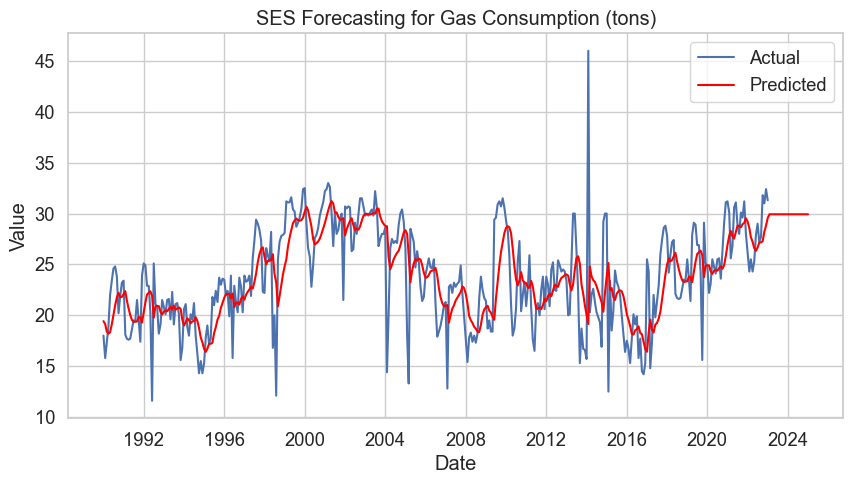

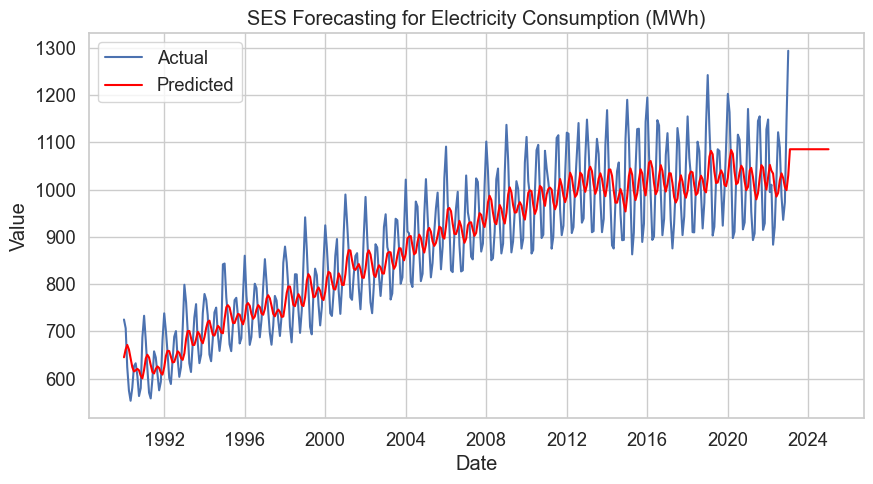

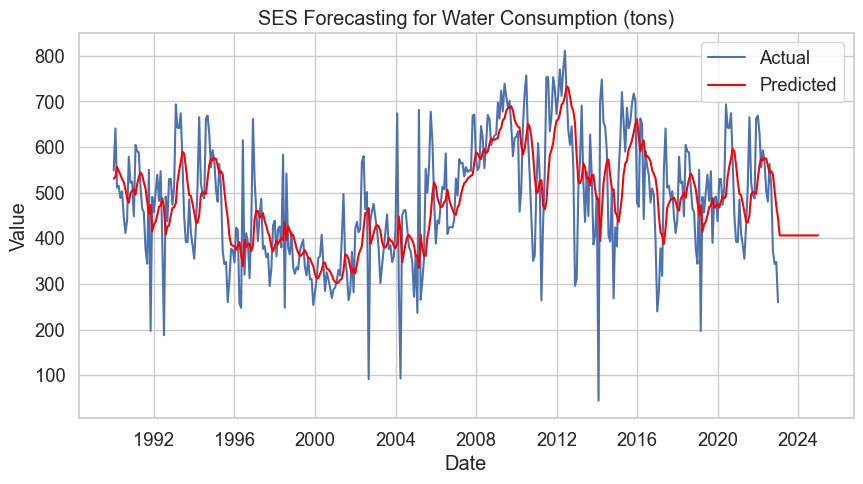

In [412]:
date_range = pd.date_range(start='1990/01/01', end = '2023-01-01', freq='M')
newdf = pd.DataFrame(df, index=date_range)

test_size = 24
n_splits = 5  
alpha = 0.21 

def expanding_window_ses(endog, test_size, n_splits, alpha):
    tscv = TimeSeriesSplit(n_splits = n_splits, test_size = test_size)
    rmse_hist = []
    
    for train_index, test_index in tscv.split(endog):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        
        model = SimpleExpSmoothing(train)
        model_fit = model.fit(smoothing_level=alpha)
        predictions = model_fit.forecast(steps=len(test))
        
        rmse_hist.append(np.sqrt(mean_squared_error(test, predictions)))
    
    return np.mean(rmse_hist)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    base_hist = dict()
    predictions_dict = {}  
    
    for column in tqdm(features):
        rmse = expanding_window_ses(endog=df[column], test_size=test_size, n_splits=n_splits, alpha=alpha)
        base_hist[column] = rmse
        
        model = SimpleExpSmoothing(df[column])
        model_fit = model.fit(smoothing_level=alpha)
        predictions = model_fit.fittedvalues.append(model_fit.forecast(steps=test_size))
        predictions_dict[column] = predictions

    base_rmse_df = pd.DataFrame(base_hist, index=['baseline_rmse']).T
    print(base_rmse_df)

for column in features:
    plt.figure(figsize=(10, 5))
    plt.plot(df[column], label='Actual')
    plt.plot(predictions_dict[column], color='red', label='Predicted')
    plt.title(f"SES Forecasting for {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# **Model Selection**
There are many models for time series. From our EDA process, I've decided to use 3 models

- ARIMA
> From Stationary tests, we found that water and gas need to be differenced for the time series to be stationary. Hence we chose ARIMA instead of ARMA as it is more able to handle differencing.
- SARIMA
> From Time Series Decompsition, we found some Seasonality in all 4 gases. Hence we will attempt to use Seasonal Autoregressive Integrated Moving Average(SARIMA) as SARIMA takes into account the seasonality patterns in the time series

## **ARIMA**

[2015-02-01    28.188154
2015-03-01    27.462760
2015-04-01    26.853763
2015-05-01    26.342487
2015-06-01    25.913251
2015-07-01    25.552891
2015-08-01    25.250354
2015-09-01    24.996363
2015-10-01    24.783127
2015-11-01    24.604108
2015-12-01    24.453814
2016-01-01    24.327637
2016-02-01    24.221706
2016-03-01    24.132773
2016-04-01    24.058110
2016-05-01    23.995428
2016-06-01    23.942804
2016-07-01    23.898624
2016-08-01    23.861533
2016-09-01    23.830394
2016-10-01    23.804251
2016-11-01    23.782304
2016-12-01    23.763878
2017-01-01    23.748408
Freq: MS, Name: predicted_mean, dtype: float64]
[2015-02-01    28.188154
2015-03-01    27.462760
2015-04-01    26.853763
2015-05-01    26.342487
2015-06-01    25.913251
2015-07-01    25.552891
2015-08-01    25.250354
2015-09-01    24.996363
2015-10-01    24.783127
2015-11-01    24.604108
2015-12-01    24.453814
2016-01-01    24.327637
2016-02-01    24.221706
2016-03-01    24.132773
2016-04-01    24.058110
2016-05-01    

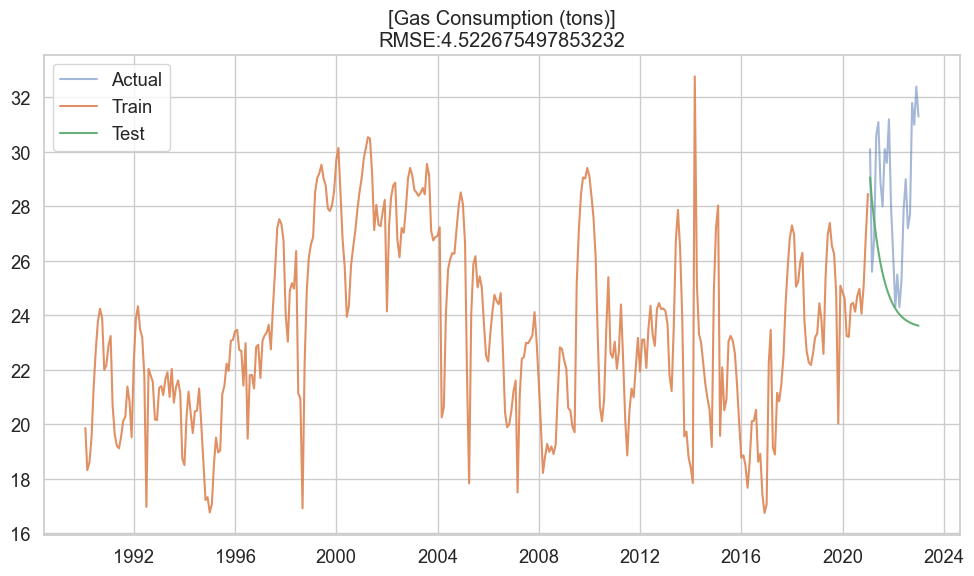

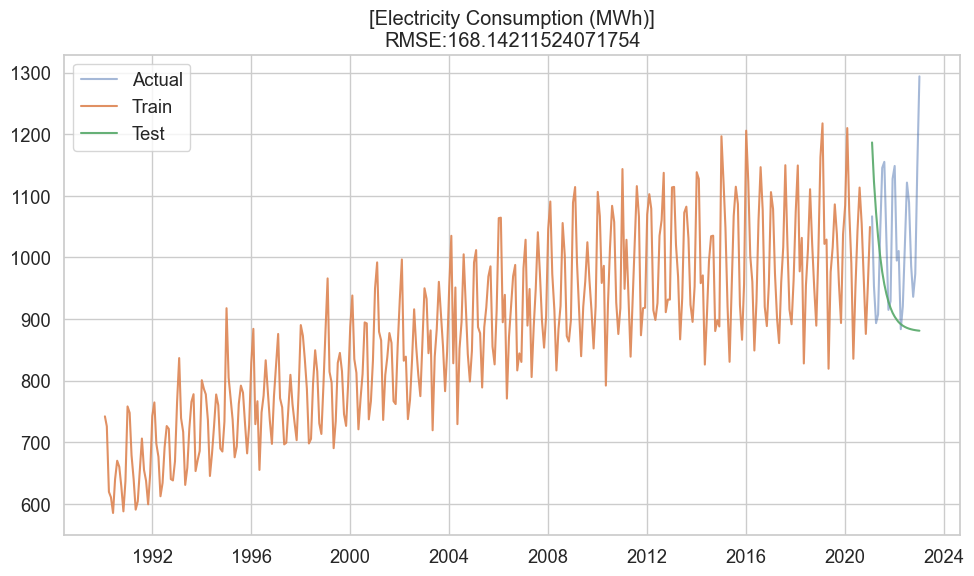

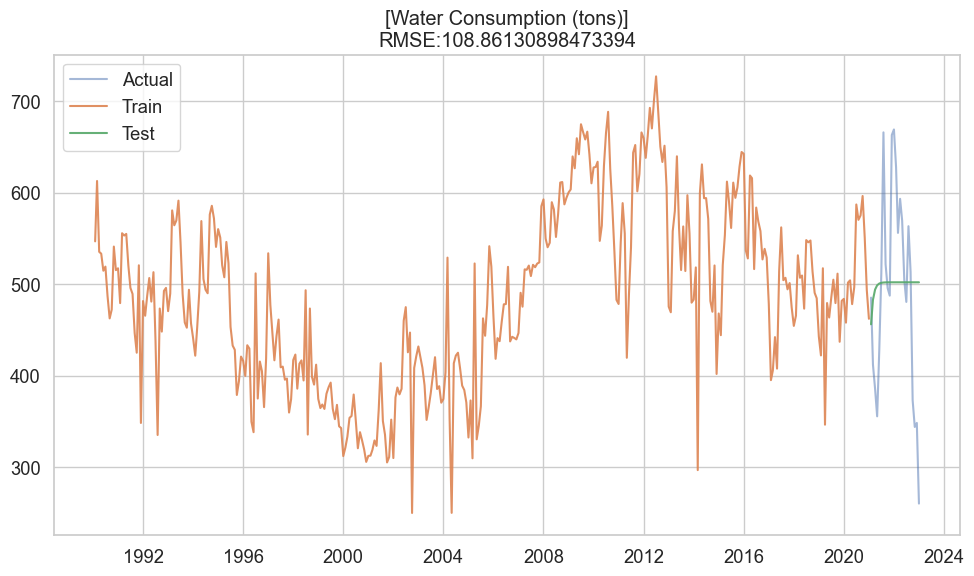

In [399]:
TEST_SIZE = 24
train_data = df.iloc[:-TEST_SIZE]
test_data = df.iloc[-TEST_SIZE:]

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def expanding_window(model, endog, test_size=TEST_SIZE, n_splits=3, **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    aic_hist = []
    predicted_values = []
    confidence_intervals = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        res = model(endog.iloc[train_index], **kwargs).fit()
        yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(rmse(ytrue, yhat))
        aic_hist.append(res.aic)
        predicted_values.append(yhat)
        print(predicted_values)
    return np.array(rmse_hist).mean(), np.array(aic_hist).mean()


for order in orders:
    
    for feature in features:
        endog_data = train_data[feature]
        rmse_mean, aic_mean = expanding_window(ARIMA, endog_data, order=order)
        hist[f'{feature} {order}'] = (rmse_mean, aic_mean)


result_df = pd.DataFrame(hist).T.rename(columns={0: "RMSE", 1: "AIC"})
result_df

for idx, order in enumerate(orders):
    target_column = features[idx]  # Use the target column name from target_vars
    mod = ARIMA(train_data[target_column], order=order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(TEST_SIZE)

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.title("[{}]\nRMSE:{}".format(target_column, rmse(test_data[target_column], pred)))
    plt.plot(test_data[target_column], label='Actual', alpha=0.5)
    plt.plot(full_pred.iloc[1:], label='Train', alpha=0.9)
    plt.plot(pred, label='Test', alpha=0.9)
    plt.legend()  # Add legend
    plt.tight_layout()  # Adjust layout
    plt.show()


## **SARIMA**

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


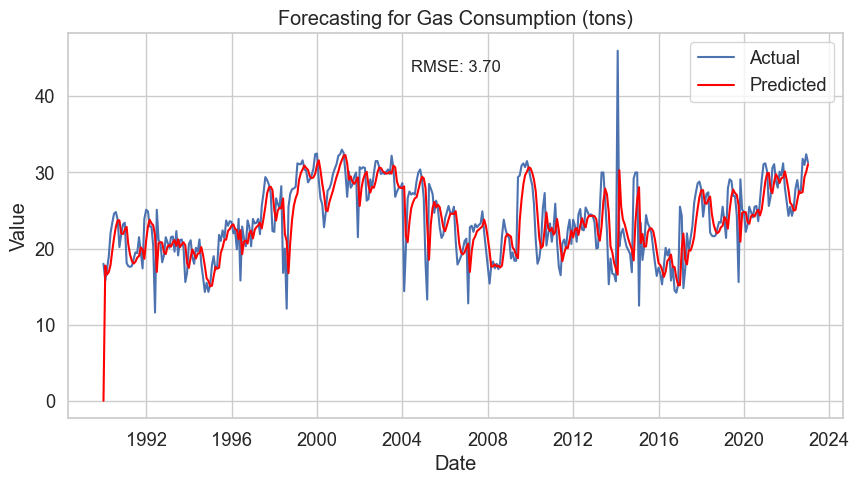

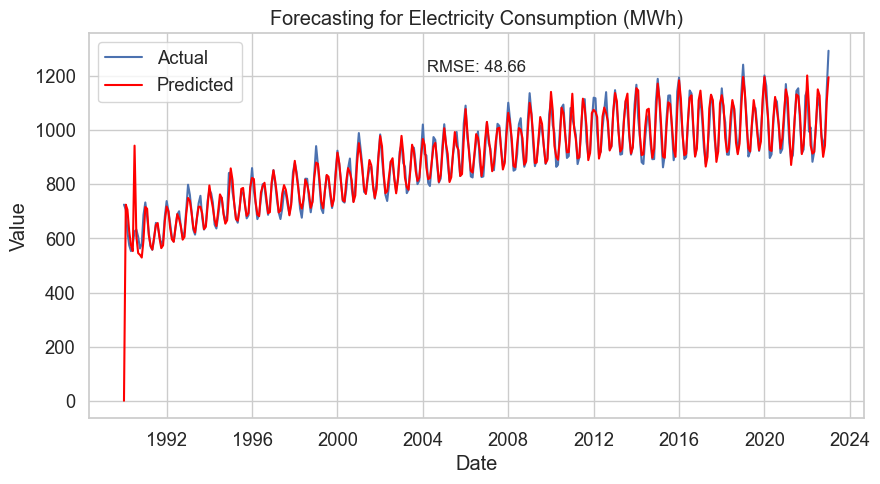

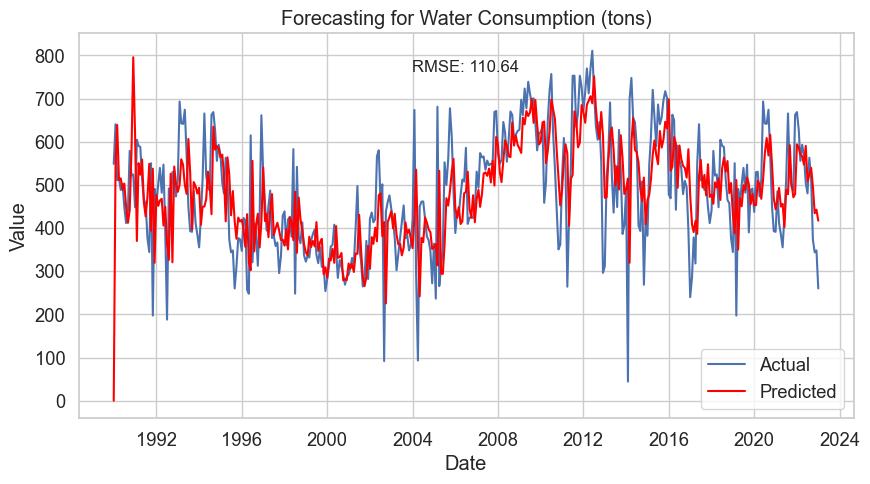

In [472]:
TEST_SIZE = 24

# Evaluation functions
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def expanding_window(model, endog, test_size=TEST_SIZE, n_splits=3, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits=n_splits)
    rmse_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        res = model(endog.iloc[train_index], order=order, seasonal_order=seasonal_order, **kwargs).fit()
        yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(rmse(ytrue, yhat))
    return np.array(rmse_hist).mean()

# Feature-specific orders and seasonal orders
feature_orders = {
    'Gas Consumption (tons)': (1, 0, 1),
    'Electricity Consumption (MWh)': (1, 1, 1),
    'Water Consumption (tons)': (1, 1, 1)
}

feature_seasonal_orders = {
    'Gas Consumption (tons)': (1, 0, 1, 12),
    'Electricity Consumption (MWh)': (1, 1, 1, 6),
    'Water Consumption (tons)': (1, 1, 1, 11)
}


# Evaluate and plot SARIMA
predictions_dict = {}

for column in tqdm(features):
    order = feature_orders[column]
    seasonal_order = feature_seasonal_orders[column]

    model = SARIMAX(df[column], order=order, seasonal_order=seasonal_order)
    res = model.fit()
    yhat = res.get_prediction(start=0, end=len(df)-1)  # Get predictions for the entire data length
    predictions_dict[column] = yhat.predicted_mean

for column in features:
    plt.figure(figsize=(10, 5))
    
    order = feature_orders[column]
    seasonal_order = feature_seasonal_orders[column]

    model = SARIMAX(df[column], order=order, seasonal_order=seasonal_order)
    res = model.fit()
    yhat = res.get_prediction(start=0, end=len(df)-1)  # Get predictions for the entire data length
    
    rmse_value = np.sqrt(mean_squared_error(df[column], yhat.predicted_mean))
    
    plt.text(0.5, 0.9, f'RMSE: {rmse_value:.2f}', transform=plt.gca().transAxes, fontsize=12, ha='center')
    
    plt.plot(df[column], label='Actual')
    plt.plot(yhat.predicted_mean, color='red', label='Predicted')
    plt.title(f"Forecasting for {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# **Hyperparameter Tuning**

So one of the things I learnt while reading online is that:
The AR and MA orders should not be the same for both the seasonal and non-seasonal components. For example, you can't have (p=3, d=1, q=3, s=3) and (p=3, d=1, q=3, s=12) because the non-seasonal and seasonal MA orders are both 3. For example, if you have (p=3, d=1, q=3, s=3) for the non-seasonal component, you cannot have (P=?, D=?, Q=3, s=12) for the seasonal component where Q is also 3. This is because using the same MA order (3) for both components could lead to confusion and overfitting, as the model might be trying to capture similar patterns in two different ways. By avoiding duplication of AR and MA orders between the non-seasonal and seasonal components, you ensure that your SARIMA model is structured in a way that effectively captures both short-term and seasonal dependencies in your time series data.

I searched for alternatives as my AR = MA, which is quite a big problem. I finally settled on changing the Q in my non-seasonal order, and the P in my seasonal order. This has the least impact on the results (or so I've read), and allows me to get the best results which is shown by my final plot and predictions.

In [434]:
!pip install --upgrade pandas

In [470]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Column name", "Order", "RMSE", "AIC"])

# Define the parameter grid
p = np.arange(0, 4)
q = np.arange(0, 4)
seasonal_orders = np.arange(3, 13)

# Loop through the parameter combinations
for feature in df.columns:
    print("Computing for feature:", feature)
    try:
        endog = df[feature]
        best_orders = []

        for i in list(product(p, q, seasonal_orders)):
            try:
                model = SARIMAX(endog=endog, order=(i[0], 1, i[1]), seasonal_order=(0, 1, 0, i[2]))
                results = model.fit()

                # Calculate RMSE
                predictions = results.get_prediction()
                rmse = np.sqrt(mean_squared_error(endog, predictions.predicted_mean))

                # Append results to the DataFrame
                results_df = results_df.append({
                    "Column name": feature,
                    "Order": i,
                    "RMSE": rmse,
                    "AIC": results.aic
                }, ignore_index=True)

            except Exception as e:
                print("Error computing:", i)
                print(e)
                pass

        # Sort the results for the current feature by RMSE and select the top 3
        best_orders_rmse = results_df[results_df["Column name"] == feature].sort_values(by="RMSE").head(3)
        best_orders.extend(best_orders_rmse["Order"])

        # Sort the results for the current feature by AIC and select the top 3
        best_orders_aic = results_df[results_df["Column name"] == feature].sort_values(by="AIC").head(3)
        best_orders.extend(best_orders_aic["Order"])

        # Remove duplicates and keep only unique best orders
        best_orders = list(set(best_orders))

        # Display the best orders for the current feature
        print("Best orders for", feature)
        for order in best_orders:
            print(order)

    except Exception as e:
        print("Error computing for feature:", feature)
        print(e)
        pass

Computing for feature: Gas Consumption (tons)
Best orders for Gas Consumption (tons)
(1, 3, 3)
(2, 3, 3)
(3, 3, 3)
Computing for feature: Electricity Consumption (MWh)
Best orders for Electricity Consumption (MWh)
(2, 2, 12)
(2, 3, 12)
(3, 2, 12)
(3, 3, 12)
(3, 1, 12)
Computing for feature: Water Consumption (tons)
Best orders for Water Consumption (tons)
(1, 3, 3)
(2, 3, 3)
(3, 3, 3)


In [489]:
# results_df.head(20)
for column in results_df['Column name'].unique():
    print("Best orders for", column)
    
    # Filter the results_df for the current column and sort by RMSE
    column_results = results_df[results_df['Column name'] == column].sort_values(by='RMSE').head(3)
    
    # Display the top 3 best orders for the current column
    for idx, row in column_results.iterrows():
        p, q, s = row['Order']
        rmse_value = row['RMSE']
        print(f"Top {idx+1}: (p={p}, d=1, q={q}, s={s}) - RMSE: {rmse_value:.6f}")

Best orders for Gas Consumption (tons)
Top 151: (p=3, d=1, q=3, s=3) - RMSE: 3.752048
Top 111: (p=2, d=1, q=3, s=3) - RMSE: 3.815090
Top 71: (p=1, d=1, q=3, s=3) - RMSE: 3.862840
Best orders for Electricity Consumption (MWh)
Top 320: (p=3, d=1, q=3, s=12) - RMSE: 49.442101
Top 280: (p=2, d=1, q=3, s=12) - RMSE: 49.524769
Top 310: (p=3, d=1, q=2, s=12) - RMSE: 49.530018
Best orders for Water Consumption (tons)
Top 471: (p=3, d=1, q=3, s=3) - RMSE: 111.215087
Top 431: (p=2, d=1, q=3, s=3) - RMSE: 112.533425
Top 391: (p=1, d=1, q=3, s=3) - RMSE: 114.656313


## **Final Plot**

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


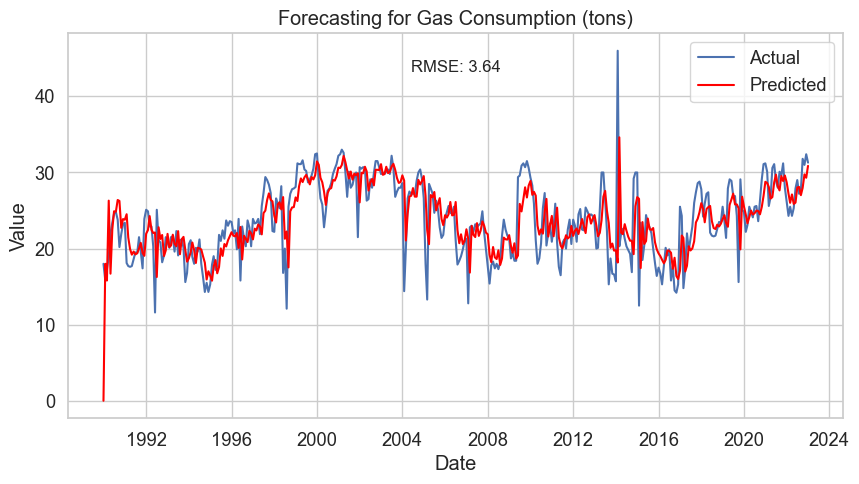

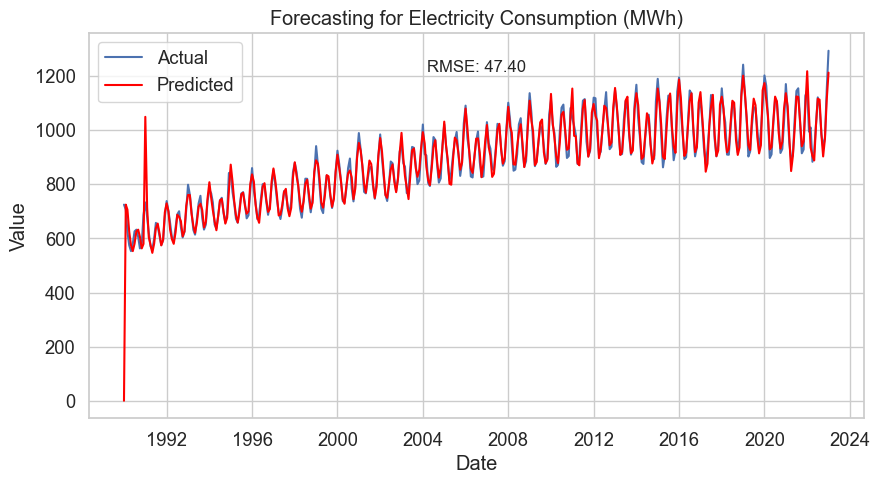

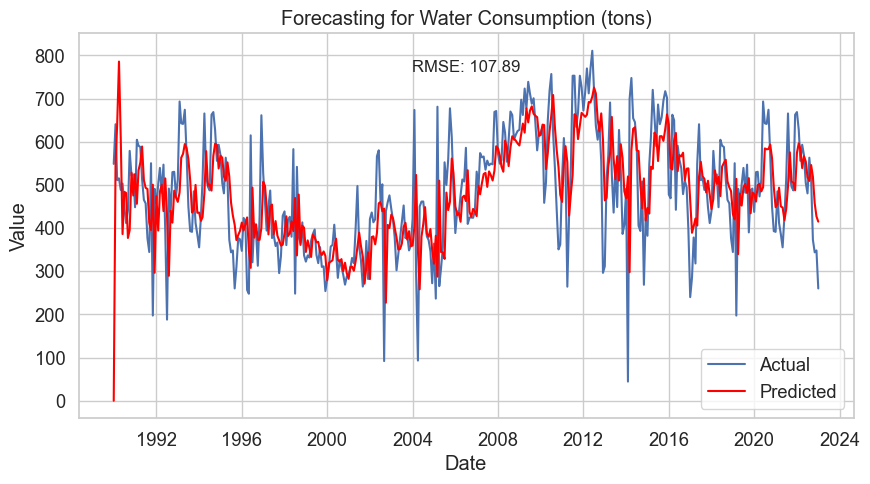

In [497]:
TEST_SIZE = 24

# Evaluation functions
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def expanding_window(model, endog, test_size=TEST_SIZE, n_splits=3, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits=n_splits)
    rmse_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        res = model(endog.iloc[train_index], order=order, seasonal_order=seasonal_order, **kwargs).fit()
        yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(rmse(ytrue, yhat))
    return np.array(rmse_hist).mean()

# Feature-specific orders and seasonal orders
feature_orders = {
    'Gas Consumption (tons)': (3, 1, 0),
    'Electricity Consumption (MWh)': (3, 1, 0),
    'Water Consumption (tons)': (3, 1, 0)
}

feature_seasonal_orders = {
    'Gas Consumption (tons)': (0, 1, 3, 3),
    'Electricity Consumption (MWh)': (0, 1, 3, 12),
    'Water Consumption (tons)': (0, 1, 3, 3)
}


# Evaluate and plot SARIMA
predictions_dict = {}

for column in tqdm(features):
    order = feature_orders[column]
    seasonal_order = feature_seasonal_orders[column]

    model = SARIMAX(df[column], order=order, seasonal_order=seasonal_order)
    res = model.fit()
    yhat = res.get_prediction(start=0, end=len(df)-1)  # Get predictions for the entire data length
    predictions_dict[column] = yhat.predicted_mean

for column in features:
    plt.figure(figsize=(10, 5))
    
    order = feature_orders[column]
    seasonal_order = feature_seasonal_orders[column]

    model = SARIMAX(df[column], order=order, seasonal_order=seasonal_order)
    res = model.fit()
    yhat = res.get_prediction(start=0, end=len(df)-1)  # Get predictions for the entire data length
    
    rmse_value = np.sqrt(mean_squared_error(df[column], yhat.predicted_mean))
    
    plt.text(0.5, 0.9, f'RMSE: {rmse_value:.2f}', transform=plt.gca().transAxes, fontsize=12, ha='center')
    
    plt.plot(df[column], label='Actual')
    plt.plot(yhat.predicted_mean, color='red', label='Predicted')
    plt.title(f"Forecasting for {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

What can 

USE UPSAMPLING AND FIND SOME BS WAY TO INTERPOLATE DATA TO BLOW CLASS AWAY

In this project, I would prefer to use an exponential expanding window. Firstly, I would rather use expanding window as we have data from 1990-2022. I feel that the loss of trends is not worth trading off to find more recent trends. Next, I picked the exponential method instead of others, such as fixed, rolling, recursive etc as I feel that it accounts the best for the flaws of the sliding window. Exponential lowers the weightage to older observations, without discarding them. This means that they will still be taken into account when predicting, but more recent observations will be prioritised. As the name exponential implies, as observations get older, the weightage exponentially decreases. Therefore, I picked the exponential expanding window.

So how do I plan on making the window? I will combine exponential smoothing and expanding window. The formula for exponential smoothing is:<br>
<div style="text-align: center;">

$\hat{Y}_t = \alpha \cdot X_t + (1 - \alpha) \cdot \hat{Y}_{t-1}$

</div>

$\alpha$ is the smoothing parameter, representing the weight assigned to the current data point. It determines the level of smoothing.<br>
$X_t$ represents the current data point.<br>
$\hat{Y}_{t-1}$ is the previous smoothed value, which serves as a reference for the current calculation.
The formula essentially takes a weighted average of the current data point and the previous smoothed value, where the weight of the current data point is determined by alpha.
Converted to code it would look like:
<div style ="text-align: center;">

$[SmoothedValues[i] = \alpha \cdot data[i]+(1 − \alpha) \cdot SmoothedValues[i−1]]$

</div>
Here we go:

<hr>

# References:

https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c<br>
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/<br>
https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/<br>
https://www.investopedia.com/terms/a/autoregressive.asp <br>
https://towardsdatascience.com/defining-the-moving-average-model-for-time-series-forecasting-in-python-626781db2502<br>
https://www.turing.com/kb/guide-to-autoregressive-models <br>
https://vitalflux.com/different-types-of-time-series-forecasting-models/ <br>
https://www.uber.com/en-SG/blog/omphalos/<br>
https://btsa.medium.com/introduction-to-exponential-smoothing-9c2d5909a714<br>
https://otexts.com/fpp2/simple-methods.html#average-method<br>
https://www.kaggle.com/code/drakonair/artificial-bee-colony<br>
https://medium.com/@ankugahlyan/understanding-artificial-bee-colony-abc-algorithm-using-numeral-example-c9c14beaa9dc<br>
https://medium.com/cesar-update/a-swarm-intelligence-approach-to-optimization-problems-using-the-artificial-bee-colony-abc-5d4c0302aaa4<br>